In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, Dataset, TensorDataset
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import time
import numpy as np
import pandas as pd
from uuid import uuid4
from typing import Dict, Union
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import os

/var/folders/fl/n022906d5c50vdkdbsnqgzhh0000gn/T/ipykernel_57883/2220684050.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [15]:
def moveTo(obj, device):
    """
    obj: the python object ot move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if isinstance(obj, list):
        return [moveTo(o, device) for o in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(o, device) for o in obj)
    elif isinstance(obj, set):
        return set(moveTo(o, device) for o in obj)
    elif isinstance(obj, dict):
        to_ret = dict()
        for k, v in obj.items():
            to_ret[moveTo(k, device)] = moveTo(v, device)
        return to_ret
    elif hasattr(obj, "to"):
        return obj.to(device)
    else:
        return obj

def run_epoch(model,
    optimizer,
    data_loader,
    loss_func,
    device,
    results,
    score_funcs,
    prefix="",
    problem_type='classification'
):
    # init empty variables
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    # loop over the batchs
    for inputs, labels in data_loader:
        # move x, y to correct device
        inputs = moveTo(inputs, device=device)
        labels = moveTo(labels, device=device)

        # estimate
        y_hat = model(inputs)

        # compute loss, backpropagate and apply gradients if needed
        loss = loss_func(y_hat, labels)
        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # store the results
        running_loss.append(loss.item())
        if score_funcs is not None and len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
        
    end = time.time()

    # clean results to compute metrics under sklearn standards
    y_pred = np.asarray(y_pred)
    if problem_type == 'classification':
        if len(y_pred.shape) == 2 and y_pred.shape[1] > 1:
            y_pred = np.argmax(y_pred, axis=1)
        if y_pred.shape[1] == 1:
            y_pred = np.where(y_pred > 0.5, 1, 0)
        
    
    results[prefix + ' loss'].append(np.mean(running_loss))
    if score_funcs is not None:
        for name, score_func in score_funcs.items():
            try:
                results[prefix + " " + name].append( score_func(y_true, y_pred) )
            except:
                results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoc

def save_model(
    model: nn.Module,
    checkpoint_file: str,
    optimizer: nn.Module,
    true_epoch: int,
    results: Dict,
    model_file_name: str = None
):
    # check if the folder for models exists
    folder_path = "checkpoints"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # save the model checkpoint
    file_name = uuid4().hex + '_' + checkpoint_file
    if model_file_name is not None:
        file_name = model_file_name
    torch.save({
        'epoch': true_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'results' : results
        }, os.path.join(folder_path, file_name))

def train_simple_network(
        model, 
        loss_func,
        train_loader,
        test_loader=None,
        score_funcs=None,
        device='cpu',
        epochs=50,
        checkpoint_file=None,
        prev_results=None,
        checkpoint_dict=None,
        checkpoint_every_x=1,
        problem_type='classification'
    ):
    # init tracking metrics
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    if score_funcs is not None:
        for eval_score in score_funcs:
            to_track.append("train " + eval_score )
            if test_loader is not None:
                to_track.append("test " + eval_score )
    total_train_time = 0
    if prev_results is None:
        results = {}
        for item in to_track:
            results[item] = []
    else:
        results = prev_results

    # initialize optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    if checkpoint_dict is not None and 'optimizer_state_dict' in checkpoint_dict.keys():
        optimizer.load_state_dict(checkpoint_dict['optimizer_state_dict'])

    # start training loop
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        # pass the model throught a epoch
        model = model.train()
        total_train_time += run_epoch(
            model, 
            optimizer, 
            train_loader, 
            loss_func, 
            device, 
            results, 
            score_funcs, 
            prefix="train",
            problem_type=problem_type
        )
    
        # grab more results from the last epoch
        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        # test the model in validation
        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test")

        # save the model checkpoint after the epoch
        true_epoch = len(results['epoch']) - 1 # useful when model and optimizer loaded
        if checkpoint_file is not None and (true_epoch % checkpoint_every_x) == 0:
            save_model(
                model=model,
                checkpoint_file=checkpoint_file,
                optimizer=optimizer,
                true_epoch=true_epoch,
                results=results
            )
    
    # save the last model
    if checkpoint_file is not None:
        save_model(
                model=model,
                checkpoint_file=checkpoint_file,
                optimizer=optimizer,
                true_epoch=true_epoch,
                results=results,
                model_file_name='last.pt'
            )

    return pd.DataFrame.from_dict(results)

### 1

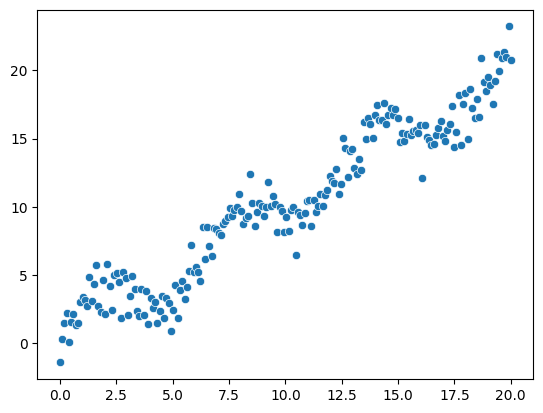

In [35]:
# datos simulados para un problema de regresion
X = np.linspace(0, 20 , num=200).reshape(-1, 1)
y = X + np.sin(X)*2 + np.random.normal(size=X.shape).reshape(-1, 1)
sns.scatterplot(x=X[:,0], y=y[:, 0])

class Simple1DRegressionDataset(Dataset):
    def __init__(self, X, y):
        super(Simple1DRegressionDataset, self).__init__()
        self.X = X
        self.y = y

    def __getitem__(self, index):
        return (
            torch.tensor(self.X[index, :], dtype=torch.float32),
            torch.tensor(self.y[index], dtype=torch.float32)    
        )
    
    def __len__(self):
        return self.X.shape[0]

training_loader = DataLoader(Simple1DRegressionDataset(X, y), shuffle=True)

In [37]:
class StandardScale1DRegressionDataset(Dataset):
    def __init__(self, X, y):
        super(StandardScale1DRegressionDataset, self).__init__()
        self.X = X
        self.y = self.standard_scale(y)
    
    @staticmethod  # probably not a staticmethod in real life 
    def standard_scale(x):
        scaler = StandardScaler()
        scaler.fit(x)
        return scaler.transform(x)

    def __getitem__(self, index):
        return (
            torch.tensor(self.X[index, :], dtype=torch.float32),
            torch.tensor(self.y[index], dtype=torch.float32)    
        )
    
    def __len__(self):
        return self.X.shape[0]

standard_training_loader = DataLoader(StandardScale1DRegressionDataset(X, y), shuffle=True)

In [38]:
# without scaling
in_features = 1
out_features = 1
model = nn.Linear(in_features, out_features)
loss_func = nn.MSELoss()

result = train_simple_network(
    model,
    loss_func,
    training_loader,
)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

In [39]:
# with scaling
in_features = 1
out_features = 1
model = nn.Linear(in_features, out_features)
loss_func = nn.MSELoss()

result_st = train_simple_network(
    model,
    loss_func,
    standard_training_loader,
)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

In [40]:
result.tail()

,epoch,total time,train loss
45,45,0.894651,3.142144
46,46,0.913349,3.181657
47,47,0.933737,3.371792
48,48,0.952956,3.253779
49,49,0.972512,3.490737


In [41]:
result_st.tail()

,epoch,total time,train loss
45,45,0.893892,0.100381
46,46,0.914667,0.100458
47,47,0.934407,0.100683
48,48,0.953704,0.100201
49,49,0.972857,0.098588


No estoy muy de acuerdo con este ejercicio, claramente (desde la grafica y sin conocer la funcion verdadera) hay una tendencia de los datos con respecto a la variable $x$, de tal manera que aplicar un `StandardScaler` en este caso es un error, primero hay que remover la tendencia y luego aplicar transformaciones. Los estimadores que adquiera el `StandardScaler` no van a ser consistentes.

### 2

<Axes: >

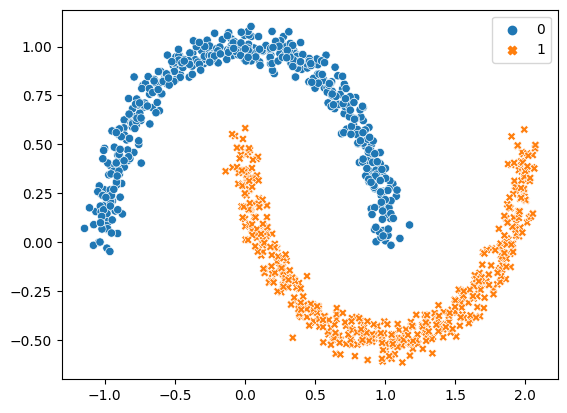

In [42]:
X, y = make_moons(n_samples=1000, noise=0.05)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, style=y)

In [44]:
X_train, y_train = make_moons(n_samples=800, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)
training_loader = DataLoader(train_dataset, shuffle=True)
testing_loader = DataLoader(test_dataset)
model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2)
)
loss_func = nn.CrossEntropyLoss()
result_pd = train_simple_network(
    model,
    loss_func,
    training_loader,
    epochs=10,
    test_loader=testing_loader,
    checkpoint_file='model.pt',
    score_funcs={'Acc': accuracy_score, 'F1': f1_score},
    checkpoint_every_x = 5
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

In [45]:
result_pd

,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1
0,0,0.145590,0.657560,0.589808,0.65875,0.760,0.530120,0.762376
1,1,0.284704,0.534642,0.506486,0.80500,0.780,0.808354,0.790476
2,2,0.423804,0.463726,0.458417,0.81750,0.795,0.821951,0.803828
3,3,0.561201,0.425976,0.434660,0.82375,0.820,0.826994,0.823529
4,4,0.699358,0.407784,0.424106,0.82625,0.815,0.827757,0.819512
5,5,0.838874,0.398957,0.417987,0.82875,0.810,0.831902,0.811881
6,6,0.977558,0.394521,0.415353,0.82500,0.810,0.827160,0.811881
7,7,1.117097,0.392101,0.413456,0.82625,0.815,0.828183,0.815920
8,8,1.254955,0.390960,0.412999,0.82625,0.810,0.827329,0.811881
9,9,1.393645,0.389873,0.413786,0.82625,0.805,0.827329,0.807882


### 3

In [46]:
def resume_simple_network(
    checkpoint_file: str, 
    model: torch.nn.Module, 
    loss_func: nn.Module,
    train_loader: DataLoader,
    test_loader: Union[DataLoader, None],
    score_funcs: Dict,
    device: str = 'cpu',
    epochs: int = 50
):
    # loading information
    checkpoint_dict = torch.load(os.path.join('checkpoints', checkpoint_file), map_location='cpu')
    model.load_state_dict(checkpoint_dict['model_state_dict'])
    # get the remainder epochs
    rem_epochs = epochs - checkpoint_dict['epoch'] - 1
    if rem_epochs < 1:
        raise ValueError(f"Total number of epochs already done {checkpoint_dict['epoch'] + 1}")
    

    results = train_simple_network(
        model=model,
        loss_func=loss_func,
        train_loader=train_loader,
        test_loader=test_loader,
        score_funcs=score_funcs,
        device=device,
        epochs=rem_epochs,
        checkpoint_file=checkpoint_file,
        prev_results=checkpoint_dict['results']
    )

    results['epoch'] = np.arange(0, len(results))

    return results

In [47]:
new_results_pd = resume_simple_network(
    checkpoint_file='last.pt',
    model=model,
    loss_func=loss_func,
    train_loader=training_loader,
    test_loader=testing_loader,
    score_funcs={'Acc': accuracy_score, 'F1': f1_score},
    device='cpu',
    epochs=30
)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

In [48]:
new_results_pd

,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1
0,0,0.145590,0.657560,0.589808,0.65875,0.760,0.530120,0.762376
1,1,0.284704,0.534642,0.506486,0.80500,0.780,0.808354,0.790476
2,2,0.423804,0.463726,0.458417,0.81750,0.795,0.821951,0.803828
3,3,0.561201,0.425976,0.434660,0.82375,0.820,0.826994,0.823529
4,4,0.699358,0.407784,0.424106,0.82625,0.815,0.827757,0.819512
5,5,0.838874,0.398957,0.417987,0.82875,0.810,0.831902,0.811881
6,6,0.977558,0.394521,0.415353,0.82500,0.810,0.827160,0.811881
7,7,1.117097,0.392101,0.413456,0.82625,0.815,0.828183,0.815920
8,8,1.254955,0.390960,0.412999,0.82625,0.810,0.827329,0.811881
9,9,1.393645,0.389873,0.413786,0.82625,0.805,0.827329,0.807882


### 4

Already done

### 5

In [49]:
X_train, y_train = make_moons(n_samples=800, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)
training_loader = DataLoader(train_dataset, shuffle=True)
testing_loader = DataLoader(test_dataset)

hiddens = [1, 2, 5, 10, 15, 20]
results_dict = {}
for hide in hiddens:
    print(f'Procesing {hide} layers')
    layers = [nn.Linear(2, 30), nn.Tanh()]
    for i in range(hide):
        layers.extend([nn.Linear(30, 30), nn.ReLU()])
    layers.append(nn.Linear(30, 2))
    model = nn.Sequential(*layers)
    loss_func = nn.CrossEntropyLoss()
    results_dict[str(hide)] = train_simple_network(
        model,
        loss_func,
        training_loader,
        epochs=100,
        test_loader=testing_loader,
        checkpoint_file=None,
        score_funcs={'Acc': accuracy_score, 'F1': f1_score},
        device='cpu'
    )

Procesing 1 layers


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Procesing 2 layers


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Procesing 5 layers


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Procesing 10 layers


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Procesing 15 layers


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Procesing 20 layers


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

In [50]:
accs = pd.DataFrame(index=list(range(100)))
for res in results_dict:
    accs[res + '_test Acc'] = results_dict[res]['test Acc']

<Axes: >

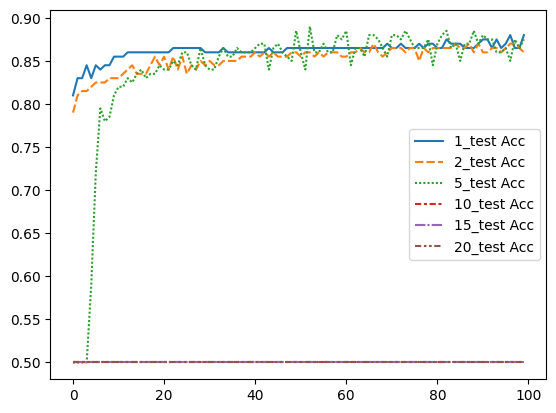

In [51]:
sns.lineplot(data=accs)

In [52]:
accs.tail(10)

,1_test Acc,2_test Acc,5_test Acc,10_test Acc,15_test Acc,20_test Acc
90,0.875,0.860,0.880,0.5,0.5,0.5
91,0.875,0.860,0.875,0.5,0.5,0.5
92,0.865,0.865,0.875,0.5,0.5,0.5
93,0.875,0.865,0.860,0.5,0.5,0.5
94,0.865,0.860,0.860,0.5,0.5,0.5
95,0.870,0.865,0.865,0.5,0.5,0.5
96,0.880,0.870,0.850,0.5,0.5,0.5
97,0.865,0.870,0.875,0.5,0.5,0.5
98,0.865,0.865,0.865,0.5,0.5,0.5
99,0.880,0.860,0.875,0.5,0.5,0.5


Resultados interesaantes, en este caso agregar mas capas no mejora sustancialmente el resultado, de hecho no hay evidencia de que mejore en absoluto, da la impresion que se necesitan mas `epochs` para entrenar de forma confiable entre mas capas hayan.

### 6

In [53]:
X_train, y_train = make_moons(n_samples=800, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)
training_loader = DataLoader(train_dataset, shuffle=True)
testing_loader = DataLoader(test_dataset)

sizes = [30, 50, 100, 512, 1024]
results_dict = {}
for size in sizes:
    print(f'Procesing {size} neurons')
    model = nn.Sequential(
        nn.Linear(2, size),
        nn.Tanh(),
        nn.Linear(size, size),
        nn.Tanh(),
        nn.Linear(size, 2)
    )
    loss_func = nn.CrossEntropyLoss()
    results_dict[str(size)] = train_simple_network(
        model,
        loss_func,
        training_loader,
        epochs=25,
        test_loader=testing_loader,
        checkpoint_file=None,
        score_funcs={'Acc': accuracy_score, 'F1': f1_score},
        device='cpu'
    )

Procesing 30 neurons


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 50 neurons


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 100 neurons


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 512 neurons


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 1024 neurons


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

<Axes: >

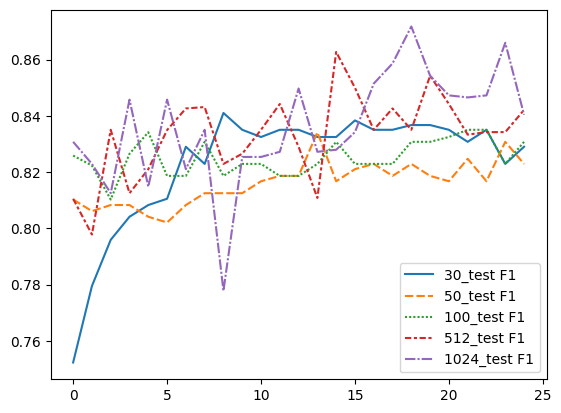

In [54]:
accs = pd.DataFrame(index=list(range(25)))
for res in results_dict:
    accs[res + '_test F1'] = results_dict[res]['test F1']

sns.lineplot(data=accs)

In [55]:
accs.tail(10)

,30_test F1,50_test F1,100_test F1,512_test F1,1024_test F1
15,0.838384,0.821053,0.822917,0.850000,0.834225
16,0.835052,0.822917,0.822917,0.835052,0.851485
17,0.835052,0.818653,0.822917,0.842640,0.858639
18,0.836735,0.822917,0.830769,0.835052,0.871795
19,0.836735,0.818653,0.830769,0.854271,0.854271
20,0.835052,0.816754,0.832487,0.844221,0.847291
21,0.830769,0.824742,0.835052,0.833333,0.846561
22,0.835052,0.816754,0.835052,0.834225,0.847291
23,0.822917,0.830769,0.822917,0.834225,0.865979
24,0.829016,0.822917,0.830769,0.842105,0.840426


In [56]:
accs.tail(10)

,30_test F1,50_test F1,100_test F1,512_test F1,1024_test F1
15,0.838384,0.821053,0.822917,0.850000,0.834225
16,0.835052,0.822917,0.822917,0.835052,0.851485
17,0.835052,0.818653,0.822917,0.842640,0.858639
18,0.836735,0.822917,0.830769,0.835052,0.871795
19,0.836735,0.818653,0.830769,0.854271,0.854271
20,0.835052,0.816754,0.832487,0.844221,0.847291
21,0.830769,0.824742,0.835052,0.833333,0.846561
22,0.835052,0.816754,0.835052,0.834225,0.847291
23,0.822917,0.830769,0.822917,0.834225,0.865979
24,0.829016,0.822917,0.830769,0.842105,0.840426


En este caso, agregar mas neuronas a la si dio resultado, por lo menos se mejoro un poco el resutado, habria que ver en la practica esto como afecta a la matriz de confusion.

### 8

In [57]:
X_train, y_train = make_moons(n_samples=800, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)

batch_sizes = [2, 4, 8, 16, 32, 64, 128, 256]
results_dict = {}
for batch_size in batch_sizes:
    training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    testing_loader = DataLoader(test_dataset, batch_size=batch_size)
    print(f'Procesing {batch_size} batch size')
    model = nn.Sequential(
        nn.Linear(2, 30),
        nn.Tanh(),
        nn.Linear(30, 30),
        nn.Tanh(),
        nn.Linear(30, 2)
    )
    loss_func = nn.CrossEntropyLoss()
    results_dict[str(batch_size)] = train_simple_network(
        model,
        loss_func,
        training_loader,
        epochs=25,
        test_loader=testing_loader,
        checkpoint_file=None,
        score_funcs={'Acc': accuracy_score, 'F1': f1_score},
        device='cpu'
    )

Procesing 2 batch size


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 4 batch size


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 8 batch size


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 16 batch size


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 32 batch size


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 64 batch size


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 128 batch size


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 256 batch size


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

<Axes: >

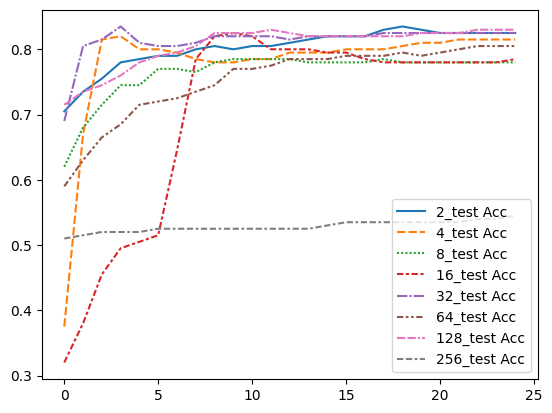

In [58]:
accs = pd.DataFrame(index=list(range(25)))
for res in results_dict:
    accs[res + '_test Acc'] = results_dict[res]['test Acc']

sns.lineplot(data=accs)

Este resultado me parece muy util, realmente se entiende el *trade-off* que hay entre velocidad de entrenamiento (en cuanto a la cantidad de `epochs`) y la rapidez con la que se llega a un minimo local (entre menos cantidad de `epochs` para llegar mejor - eje $x$ son los `epochs`)

### 7

In [4]:
from sklearn.datasets import load_breast_cancer

In [5]:
data_dict = load_breast_cancer()
print(data_dict['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [6]:
data_dict.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [7]:
data_dict['data'].shape

(569, 30)

In [8]:
data_dict['target'].shape

(569,)

In [41]:
breast_dataset = TensorDataset(
    torch.tensor(data_dict['data'], dtype=torch.float32),
    torch.tensor(data_dict['target'].reshape(-1, 1), dtype=torch.float32)
)

# split between train and validation
train_size = int(len(breast_dataset)*0.8)
test_size = len(breast_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    breast_dataset, [train_size, test_size]
)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

model = nn.Sequential(
    nn.Linear(30, 64),
    nn.Tanh(),
    nn.Linear(64, 128),
    nn.Tanh(),
    nn.Linear(128, 1024),
    nn.Tanh(),
    nn.Linear(1024, 1024),
    nn.Tanh(),
    nn.Linear(1024, 64),
    nn.Tanh(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)
loss_func = nn.BCELoss()
results = train_simple_network(
    model=model,
    loss_func=loss_func,
    train_loader=train_loader,
    epochs=25,
    test_loader=test_loader,
    checkpoint_file=None,
    device='cpu',
    score_funcs={'Acc': accuracy_score}
)

results

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

,epoch,total time,train loss,test loss,train Acc,test Acc
0,0,0.044440,0.687220,0.684077,0.630769,0.649123
1,1,0.099251,0.681930,0.679215,0.621978,0.649123
2,2,0.140179,0.676508,0.674196,0.621978,0.649123
3,3,0.177891,0.671958,0.669278,0.621978,0.649123
4,4,0.216506,0.666925,0.664568,0.621978,0.649123
5,5,0.276871,0.661939,0.659626,0.621978,0.649123
6,6,0.316422,0.659869,0.654749,0.621978,0.649123
7,7,0.353882,0.654143,0.650294,0.621978,0.649123
8,8,0.392464,0.650497,0.646245,0.621978,0.649123
9,9,0.429708,0.644259,0.642395,0.621978,0.649123
